In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torchaudio
import soundfile as sf
import seaborn as sns

from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import Audio

from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from birdnetlib.batch import DirectoryMultiProcessingAnalyzer

### Config

In [88]:
train_dir = Path('E:\data\BirdCLEF')

class CFG:
    random_seed = 42

    include_ul = True
    
    split_fraction = 0.95
    
    ROOT_FOLDER = train_dir
    AUDIO_FOLDER = train_dir / 'train_audio'
    DATA_DIR = train_dir / 'spectros'
    TRAIN_CSV = train_dir / 'train_metadata.csv'
    RESULTS_DIR = train_dir / 'results'
    CKPT_DIR = RESULTS_DIR / 'ckpt'
    bird20223 = train_dir / 'bird2023.csv'
    UNLABELED_FOLDER = train_dir / 'unlabeled_soundscapes'

    bird_preds_csv = train_dir / 'bird_preds.csv'
    unlabeled_preds_csv = train_dir / 'unlabeled_preds.csv'
    taxonomy_csv = train_dir / 'eBird_Taxonomy_v2021.csv'

In [89]:
sec_labels = ['lotshr1', 'orhthr1', 'magrob', 'indwhe1', 'bltmun1', 'asfblu1']

sample_submission = pd.read_csv(train_dir / 'sample_submission.csv')

# Set labels
CFG.LABELS = sample_submission.columns[1:].tolist()
bird2id = {b: i for i, b in enumerate(CFG.LABELS)}

len(CFG.LABELS)

182

In [184]:
meta_df = pd.read_csv(CFG.TRAIN_CSV)
df_23 = pd.read_csv(CFG.bird20223)
bird_preds_df = pd.read_csv(CFG.bird_preds_csv)
unlabeled_preds_df = pd.read_csv(CFG.unlabeled_preds_csv)
taxonomy_df = pd.read_csv(CFG.taxonomy_csv)

df_23.shape, bird_preds_df.shape, unlabeled_preds_df.shape, taxonomy_df.shape

((16941, 12), (254, 7), (27203, 5), (16753, 9))

In [160]:
print(meta_df.filename.duplicated().sum())
meta_df['file'] = meta_df.apply(lambda row: row.filename.split('/')[-1], axis=1)

0


In [176]:
all_files = meta_df.filename.unique().tolist()
len(all_files)

24459

In [178]:
# durations = {}
# for f in all_files:
#     filename = CFG.AUDIO_FOLDER / f
#     info = torchaudio.info(filename)
#     duration = int(info.num_frames / info.sample_rate )

#     durations[f] = duration

# meta_df['duration'] = meta_df.apply(lambda row: durations[row['filename']], axis=1)

# meta_df.to_csv(CFG.TRAIN_CSV, index=False) 

In [218]:
meta_df[meta_df['duration'] > 60].shape, meta_df['duration'].max()

((4021, 14), 5964)

In [227]:
meta_df[meta_df['duration'] < 7].shape, meta_df[meta_df['duration'] < 7].primary_label.nunique()

((2678, 14), 170)

In [225]:
meta_df[(meta_df['duration'] < 7) & (meta_df['secondary_labels'] == '[]')].primary_label.nunique()

170

In [226]:
meta_df[meta_df['duration'] < 7].sample(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,file,duration
10542,graher1,[],"['flight call', 'nocturnal flight call']",52.1638,106.3710,Ardea cinerea,Gray Heron,Stanislas Wroza,Creative Commons Attribution-NonCommercial-Sha...,0.0,https://www.xeno-canto.org/487206,graher1/XC487206.ogg,XC487206.ogg,6
23273,whtkin2,[],"['alarm call', 'call', 'flight call']",21.0491,75.8634,Halcyon smyrnensis,White-throated Kingfisher,Lakshmikant Rajaram Neve,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/392132,whtkin2/XC392132.ogg,XC392132.ogg,4


In [208]:
meta_df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,file,duration
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,XC134896.ogg,27
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,XC164848.ogg,15


In [162]:
taxonomy_df.head(2)

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN


In [163]:
all_birds = taxonomy_df.SCI_NAME.unique().tolist()
bird_codes = taxonomy_df.SPECIES_CODE.unique().tolist()

sci2code = {b: c for b, c in zip(all_birds, bird_codes)}
code2sci = {c:b for b, c in zip(all_birds, bird_codes)}

In [164]:
sci2code['Struthio camelus'], code2sci['ostric2']

('ostric2', 'Struthio camelus')

### BirdNet train predictions

In [165]:
bird_preds_df.sample(2)

,filename,label,name,start,end,duration,confidence
218,XC839572.ogg,asbfly,Muscicapa dauurica,81.0,84.0,-1,0.984935
182,XC825177.ogg,asbfly,Muscicapa dauurica,36.0,39.0,-1,0.985808


In [166]:
# bird_preds_df['path'] = fr'{str(CFG.AUDIO_FOLDER)}/' + bird_preds_df['label'] + '/' + bird_preds_df['filename']

In [167]:
# bird_preds_df[bird_preds_df['filename'] == 'XC496054.ogg']

In [168]:
bird_preds_df.sample(4)

,filename,label,name,start,end,duration,confidence
44,XC376509.ogg,asbfly,Coccothraustes coccothraustes,33.0,36.0,-1,0.812402
251,XC858110.ogg,asbfly,Muscicapa dauurica,30.0,33.0,-1,0.994005
192,XC827640.ogg,asbfly,Muscicapa dauurica,21.0,24.0,-1,0.833466
183,XC825177.ogg,asbfly,Muscicapa dauurica,42.0,45.0,-1,0.955030


In [169]:
bird_preds_df['pred_code'] = bird_preds_df.apply(lambda row: sci2code[row['name']] if row['name'] in sci2code.keys() else '', axis=1)
bird_preds_df['ood'] = bird_preds_df.apply(lambda row: False if row['pred_code'] in bird2id.keys() else True, axis=1)

In [170]:
bird_preds_df.shape, bird_preds_df[bird_preds_df['pred_code'] == ''].shape

((254, 9), (0, 9))

In [171]:
bird_preds_df[bird_preds_df['ood'] == True].shape

(23, 9)

In [172]:
ood_list = bird_preds_df[bird_preds_df['ood'] == True].pred_code.unique().tolist()
len(ood_list)

15

In [174]:
bird_preds_df[bird_preds_df['duration'] != -1]

,filename,label,name,start,end,duration,confidence,pred_code,ood


In [173]:
bird_preds_df.sample(2)

,filename,label,name,start,end,duration,confidence,pred_code,ood
241,XC858110.ogg,asbfly,Muscicapa dauurica,0.0,3.0,-1,0.995944,asbfly,False
178,XC825177.ogg,asbfly,Muscicapa dauurica,12.0,15.0,-1,0.979883,asbfly,False


In [105]:
bird_preds_df.label.value_counts()[:15]

label
blrwar1    13281
hoopoe      6506
comros      4259
grewar3     4117
bkwsti      3751
eucdov      3539
barswa      3340
zitcis1     2713
comgre      2400
rorpar      2357
comsan      2335
woosan      2311
graher1     2231
grywag      2230
lirplo      2111
Name: count, dtype: int64

### Unlabeled soundscapes

In [106]:
unlabeled_preds_df.sample(2)

,filename,name,start,end,confidence
25580,899208617.ogg,Irena puella,45.0,48.0,0.862166
10925,1774227206.ogg,Leptocoma minima,222.0,225.0,0.993479


In [107]:
unlabeled_preds_df['pred_code'] = unlabeled_preds_df.apply(lambda row: sci2code[row['name']] if row['name'] in sci2code.keys() else '', axis=1)
unlabeled_preds_df['label'] = unlabeled_preds_df['pred_code']
unlabeled_preds_df['ood'] = unlabeled_preds_df.apply(lambda row: False if row['pred_code'] in bird2id.keys() else True, axis=1)

In [108]:
unlabeled_preds_df['path'] = fr'{str(CFG.UNLABELED_FOLDER)}/' + unlabeled_preds_df['filename']

In [109]:
unlabeled_preds_df.sample(2)

,filename,name,start,end,confidence,pred_code,label,ood,path
3719,1273762750.ogg,Myophonus horsfieldii,81.0,84.0,0.958053,mawthr1,mawthr1,False,E:\data\BirdCLEF\unlabeled_soundscapes/1273762...
10014,1697952212.ogg,Alcippe poioicephala,48.0,51.0,0.789011,brcful1,brcful1,False,E:\data\BirdCLEF\unlabeled_soundscapes/1697952...


In [110]:
unlabeled_preds_df.shape, unlabeled_preds_df[unlabeled_preds_df['pred_code'] == ''].shape

((27203, 9), (351, 9))

In [111]:
unlabeled_preds_df[unlabeled_preds_df['ood'] == False].shape

(18295, 9)

In [112]:
unlabeled_preds_df[unlabeled_preds_df['ood'] == False].sample(4)

,filename,name,start,end,confidence,pred_code,label,ood,path
1754,1132499652.ogg,Leptocoma minima,144.0,147.0,0.756498,crbsun2,crbsun2,False,E:\data\BirdCLEF\unlabeled_soundscapes/1132499...
6746,1495694736.ogg,Pomatorhinus horsfieldii,99.0,102.0,0.974305,insbab1,insbab1,False,E:\data\BirdCLEF\unlabeled_soundscapes/1495694...
2668,1212125127.ogg,Gracula indica,24.0,27.0,0.999774,sohmyn1,sohmyn1,False,E:\data\BirdCLEF\unlabeled_soundscapes/1212125...
16855,269289125.ogg,Gallus sonneratii,45.0,48.0,0.865619,grejun2,grejun2,False,E:\data\BirdCLEF\unlabeled_soundscapes/2692891...


### Low freq classes

In [113]:
labels_pred = bird_preds_df.pred_code.unique().tolist()

missing = list(set(CFG.LABELS) - set(labels_pred))
extra = list(set(labels_pred) - set(CFG.LABELS))

len(labels_pred), len(missing), len(extra)

(1180, 4, 1002)

In [114]:
labels_pred = bird_preds_df[bird_preds_df['ood'] == False].pred_code.unique().tolist()

extra = list(set(labels_pred) - set(CFG.LABELS))
len(extra)

0

In [115]:
missing

['inpher1', 'darter2', 'niwpig1', 'brfowl1']

In [116]:
'darter2' in labels_pred

False

In [117]:
counts = bird_preds_df.label.value_counts()
# bird_preds_df.label.isin(counts[counts < 1000]).index.tolist()
counts[counts > 1000].count(), counts[counts < 50].count(), counts.count()

(29, 30, 179)

In [118]:
counts = bird_preds_df.pred_code.value_counts()
counts[counts > 1000].count(), counts[counts < 50].count(), counts[counts < 10].count(), len(CFG.LABELS)

(29, 999, 817, 182)

In [119]:
ood_df = bird_preds_df[bird_preds_df['ood'] == False]
counts = ood_df.pred_code.value_counts()
counts[counts > 1000].count(), counts[counts < 50].count(), counts[counts < 10].count(), len(CFG.LABELS)

(29, 31, 8, 182)

In [120]:
bird_preds_df.shape,  ood_df.shape

((123023, 8), (114336, 8))

In [121]:
# bird_preds_df.label.value_counts()[-20:]

In [122]:
bird_preds_df[bird_preds_df['filename'] == 'XC49755.ogg']

,filename,label,name,start,end,confidence,pred_code,ood


In [123]:
bird_preds_df[bird_preds_df['label'] != bird_preds_df['pred_code']]

,filename,label,name,start,end,confidence,pred_code,ood
8,XC209218.ogg,asbfly,Muscicapa striata,30.0,33.0,0.818781,spofly1,True
9,XC267683.ogg,asbfly,Cyanoptila cyanomelana,0.0,3.0,0.907427,bawfly2,True
32,XC313835.ogg,asbfly,Horornis fortipes,3.0,6.0,0.961619,bfbwar1,True
33,XC313835.ogg,asbfly,Horornis fortipes,12.0,15.0,0.853916,bfbwar1,True
35,XC342037.ogg,asbfly,Phylloscopus borealis,51.0,54.0,0.885017,arcwar1,True
...,...,...,...,...,...,...,...,...
122990,XC839550.ogg,zitcis1,Helopsaltes pryeri,24.0,27.0,0.925592,margra1,True
122994,XC844802.ogg,zitcis1,Corvus monedula,3.0,6.0,0.929795,eurjac,True
122995,XC844802.ogg,zitcis1,Corvus monedula,9.0,12.0,0.904496,eurjac,True
122999,XC845747.ogg,zitcis1,Himantopus himantopus,0.0,3.0,0.918337,bkwsti,False


In [124]:
# meta_df[meta_df['secondary_labels'] == '[]'].primary_label.value_counts()

### Post process predictions

In [125]:
from utils import cat_feature_dist, downsample_data, upsample_data

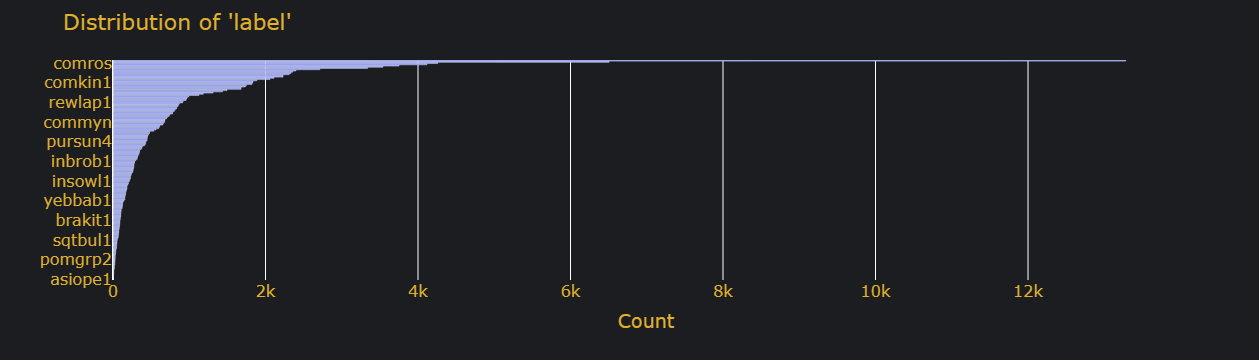


Total unique values in 'label'are: 179

Top 5 values: label
blrwar1    13281
hoopoe      6506
comros      4259
grewar3     4117
bkwsti      3751
Name: count, dtype: int64

Bottom 5 values: label
indtit1    8
brfowl1    6
bncwoo3    5
niwpig1    2
asiope1    1
Name: count, dtype: int64


In [126]:
cat_feature_dist(bird_preds_df, 'label')

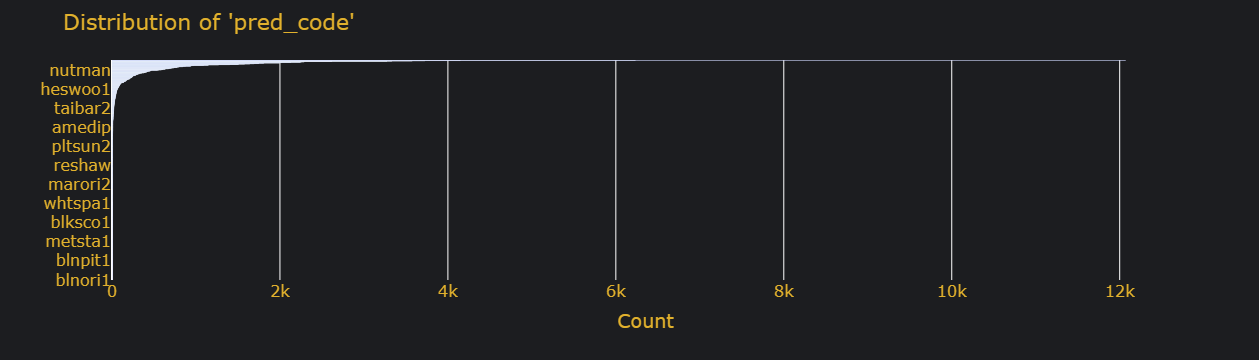


Total unique values in 'pred_code'are: 1180

Top 5 values: pred_code
blrwar1    12071
hoopoe      6233
comros      4148
grewar3     3727
bkwsti      3575
Name: count, dtype: int64

Bottom 5 values: pred_code
dusant1    1
padwar1    1
subwar6    1
ausgre1    1
blnori1    1
Name: count, dtype: int64


In [127]:
cat_feature_dist(bird_preds_df, 'pred_code')

In [128]:
preds = bird_preds_df[bird_preds_df['ood'] == False]
preds.shape, bird_preds_df.shape

((114336, 8), (123023, 8))

# Pretraing Dataset
> Original: 90128
> After Upsample: 50312
> After Downsample: 47116


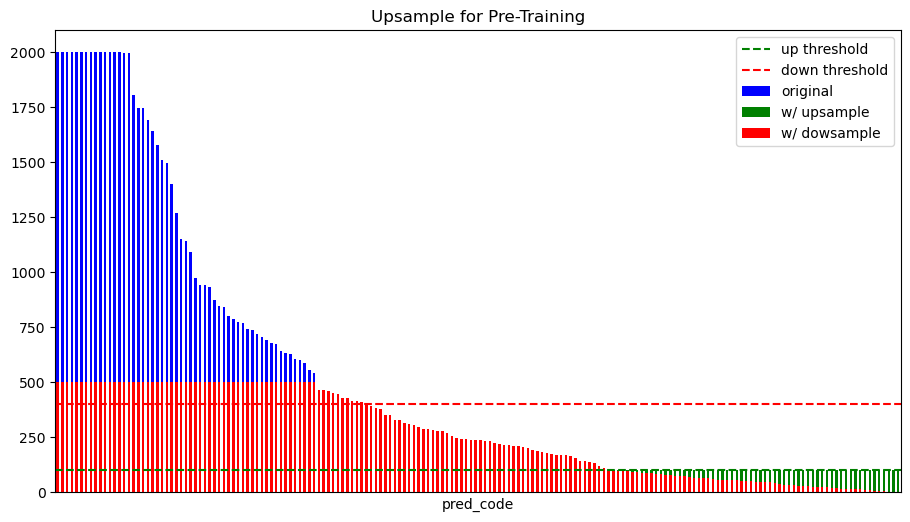

In [129]:
# Upsample data
up_thr = 100
# pre downsample for graphical reasons, remove very high classes
pre_df = bird_preds_df[bird_preds_df['ood'] == False]
pre_df = downsample_data(pre_df, 'pred_code', thr=2000, seed=CFG.random_seed)
dn_df = downsample_data(pre_df, 'pred_code', thr=500, seed=CFG.random_seed)
up_df = upsample_data(dn_df, 'pred_code', thr=up_thr, seed=CFG.random_seed)

print("# Pretraing Dataset")
print(f'> Original: {len(pre_df)}')
print(f'> After Upsample: {len(up_df)}')
print(f'> After Downsample: {len(dn_df)}')

# Show effect of upsample
plt.figure(figsize=(12*2, 6))

ax1 = plt.subplot(1, 2, 1)
pre_df.pred_code.value_counts()[:].plot.bar(color='blue', label='original')
up_df.pred_code.value_counts()[:].plot.bar(color='green', label='w/ upsample')
dn_df.pred_code.value_counts()[:].plot.bar(color='red', label='w/ dowsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.axhline(y=400, color='r', linestyle='--', label='down threshold')
plt.legend()
plt.title("Upsample for Pre-Training")

# plt.tight_layout()
plt.show()

### Preprocess training data

In [130]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

In [131]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=1-CFG.split_fraction, random_state=CFG.random_seed)
train_idx, val_idx = next(sss.split(meta_df.filename, meta_df.primary_label))

t_df = meta_df.iloc[train_idx]
v_df = meta_df.iloc[val_idx]

t_df.shape, v_df.shape

((23236, 13), (1223, 13))

In [132]:
files = t_df.filename.tolist()
v_df.apply(lambda row: row['filename'] in files, axis=1).sum()

0

In [133]:
# Use only classes that are in distribution (western ghats)
df = bird_preds_df[bird_preds_df['ood'] == False]
df.shape, bird_preds_df.shape

((114336, 8), (123023, 8))

In [134]:
labels_pred = bird_preds_df.pred_code.unique().tolist()

missing = list(set(CFG.LABELS) - set(labels_pred))
extra = list(set(labels_pred) - set(CFG.LABELS))

len(labels_pred), len(missing), len(extra)

(1180, 4, 1002)

In [135]:
# missing labels
missing

['inpher1', 'darter2', 'niwpig1', 'brfowl1']

In [136]:
# underrepressented labels
counts = df.pred_code.value_counts()
labels_under = counts[counts < 10]

counts[counts < 50].count(), labels_under.count(), labels_under.index.tolist()

(31,
 8,
 ['wbbfly1',
  'nilfly2',
  'blaeag1',
  'wynlau1',
  'indtit1',
  'bncwoo3',
  'integr',
  'asiope1'])

In [137]:
missing += labels_under.index.tolist()
len(missing), missing

(12,
 ['inpher1',
  'darter2',
  'niwpig1',
  'brfowl1',
  'wbbfly1',
  'nilfly2',
  'blaeag1',
  'wynlau1',
  'indtit1',
  'bncwoo3',
  'integr',
  'asiope1'])

In [138]:
df.head(2)

,filename,label,name,start,end,confidence,pred_code,ood
0,XC134896.ogg,asbfly,Muscicapa dauurica,0.0,3.0,0.964252,asbfly,False
1,XC134896.ogg,asbfly,Muscicapa dauurica,6.0,9.0,0.993391,asbfly,False


In [139]:
# meta_df.head(2)

In [140]:
results = []
soft_label = 0.9
frame = 3 # seconds

for label in missing:
    files = meta_df[meta_df['primary_label'] == label].filename.tolist()
    
    for f in files:
        path = CFG.AUDIO_FOLDER / f
        wav, org_sr = torchaudio.load(path)

        duration = int(wav.shape[1] / org_sr)

        steps = list(range(0, duration, frame))

        filename = f.split('/')[-1] 

        intervals = [(x,x+frame) for x in steps[:-1]]
        
        data = [(filename, label, code2sci[label], i[0], i[1], soft_label, label, False) for i in intervals]
        results.append(pd.DataFrame(data, columns = ['filename', 'label', 'name', 'start', 'end', 'confidence', 'pred_code', 'ood']))

    # break
len(results), df.isnull().values.any()

(98, False)

In [141]:
# for r in results:
#    print (r.isnull().values.any())

In [142]:
# merge dfs and upsample
results_df = pd.concat(results, axis=0)
print(results_df.shape)

results_df.sample(2)

(900, 8)


C:\Users\Asus\AppData\Local\Temp\ipykernel_28380\2215103872.py:2: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,filename,label,name,start,end,confidence,pred_code,ood
0,XC548372.ogg,nilfly2,Eumyias albicaudatus,0,3,0.9,nilfly2,False
1,XC741495.ogg,bncwoo3,Yungipicus nanus,3,6,0.9,bncwoo3,False


In [143]:
df.head(2)

,filename,label,name,start,end,confidence,pred_code,ood
0,XC134896.ogg,asbfly,Muscicapa dauurica,0.0,3.0,0.964252,asbfly,False
1,XC134896.ogg,asbfly,Muscicapa dauurica,6.0,9.0,0.993391,asbfly,False


In [144]:
df = pd.concat([df,results_df], axis=0)
df.shape

(115236, 8)

In [145]:
df['start'] = df['start'].astype(int)
df['end'] = df['end'].astype(int)

df['path'] = fr'{str(CFG.AUDIO_FOLDER)}/' + df['label'] + '/' + df['filename']

In [146]:
df.head(2)

,filename,label,name,start,end,confidence,pred_code,ood,path
0,XC134896.ogg,asbfly,Muscicapa dauurica,0,3,0.964252,asbfly,False,E:\data\BirdCLEF\train_audio/asbfly/XC134896.ogg
1,XC134896.ogg,asbfly,Muscicapa dauurica,6,9,0.993391,asbfly,False,E:\data\BirdCLEF\train_audio/asbfly/XC134896.ogg


In [147]:
labels_pred = bird_preds_df.pred_code.unique().tolist()

missing = list(set(CFG.LABELS) - set(labels_pred))
extra = list(set(labels_pred) - set(CFG.LABELS))

len(labels_pred), len(missing), len(extra)

(1180, 4, 1002)

In [148]:
# check missing again
labels_pred = df.pred_code.unique().tolist()

missing = list(set(CFG.LABELS) - set(labels_pred))
extra = list(set(labels_pred) - set(CFG.LABELS))

len(labels_pred), len(missing), len(extra)

(182, 0, 0)

### Filter preds based on files from split

In [149]:
train_files = t_df.file.unique().tolist()
val_files = v_df.file.unique().tolist()

len(train_files), len(val_files)

(23219, 1223)

In [150]:
train_df = df[df.filename.isin(train_files)]
val_df = df[df.filename.isin(val_files)]

train_df.shape, val_df.shape, df.shape

((110266, 9), (4970, 9), (115236, 9))

### Add unlabeled

In [151]:
unl_df = unlabeled_preds_df[unlabeled_preds_df['ood'] == False]
unl_df.shape

(18295, 9)

In [152]:
# unl_df['label'] = unl_df['pred_code']

In [153]:
train_df.head(2)

,filename,label,name,start,end,confidence,pred_code,ood,path
0,XC134896.ogg,asbfly,Muscicapa dauurica,0,3,0.964252,asbfly,False,E:\data\BirdCLEF\train_audio/asbfly/XC134896.ogg
1,XC134896.ogg,asbfly,Muscicapa dauurica,6,9,0.993391,asbfly,False,E:\data\BirdCLEF\train_audio/asbfly/XC134896.ogg


In [154]:
unl_df.head(2)

,filename,name,start,end,confidence,pred_code,label,ood,path
0,1000424265.ogg,Myophonus horsfieldii,24.0,27.0,0.939526,mawthr1,mawthr1,False,E:\data\BirdCLEF\unlabeled_soundscapes/1000424...
2,100065465.ogg,Phylloscopus trochiloides,36.0,39.0,0.841660,grewar3,grewar3,False,E:\data\BirdCLEF\unlabeled_soundscapes/1000654...


In [155]:
print(train_df.shape)

if CFG.include_ul:
    train_df = pd.concat([train_df, unl_df], axis=0)

print(train_df.shape)

(110266, 9)
(128561, 9)


### Up/down sample train dataset

# Pretraing Dataset
> Original: 103762
> After Upsample: 50498
> After Downsample: 44990


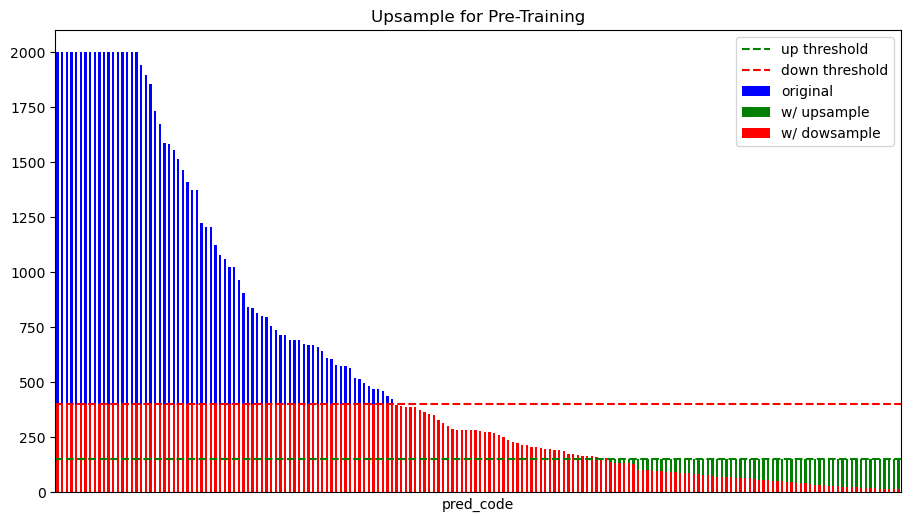

In [156]:
# Upsample data

# label = 'label'
label = 'pred_code'

up_thr = 150
down_thr = 400
# pre downsample for graphical reasons, remove very high classes
# pre_df = bird_preds_df[bird_preds_df['ood'] == False]
pre_df = train_df
pre_df = downsample_data(pre_df, label, thr=2000, seed=CFG.random_seed)
dn_df = downsample_data(pre_df, label, thr=down_thr, seed=CFG.random_seed)
up_df = upsample_data(dn_df, label, thr=up_thr, seed=CFG.random_seed)

print("# Pretraing Dataset")
print(f'> Original: {len(pre_df)}')
print(f'> After Upsample: {len(up_df)}')
print(f'> After Downsample: {len(dn_df)}')

# Show effect of upsample
plt.figure(figsize=(12*2, 6))

ax1 = plt.subplot(1, 2, 1)
pre_df[label].value_counts()[:].plot.bar(color='blue', label='original')
up_df[label].value_counts()[:].plot.bar(color='green', label='w/ upsample')
dn_df[label].value_counts()[:].plot.bar(color='red', label='w/ dowsample')
plt.xticks([])
plt.axhline(y=up_thr, color='g', linestyle='--', label='up threshold')
plt.axhline(y=400, color='r', linestyle='--', label='down threshold')
plt.legend()
plt.title("Upsample for Pre-Training")

# plt.tight_layout()
plt.show()

In [157]:
up_df.shape, val_df.shape

((50498, 9), (4970, 9))

In [158]:
# Save datasets
up_df.to_csv(train_dir / "train_set.csv", index=False) 
val_df.to_csv(train_dir / "val_set.csv", index=False) 